In [9]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from dataloader.dataloader import DataLoader
from preprocessing.clustering_segmentation import ClusteringSegmentation
from preprocessing.edge_detection import EdgeDetection
from preprocessing.image_restoration import ImageRestorer
from preprocessing.preproccessing import ImagePreprocessor
from preprocessing.region_segmentation import RegionBasedSegmentation
from preprocessing.threshold_segmentation import ThresholdSegmentation
from feature_extraction.feature_extraction import FeatureExtractor
# from feature_selection.feature_selection import FeatureSelection
from model_selection.model_selection import ModelSelection
from performance_analysis.performance_analysis import PerformanceAnalysis

import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

In [2]:
dataloader = DataLoader(Path('./data'))

In [3]:
# Load Data from files
x_train, y_train, x_test, y_test, x_val, y_val = dataloader.load_data()

Image data\men\2\2_men (107).JPG is corrupted
Image data\men\2\2_men (108).JPG is corrupted
Image data\men\3\3_men (140).JPG is corrupted
Image data\men\3\3_men (141).JPG is corrupted
Image data\men\4\4_men (5).JPG is corrupted
Image data\men\4\4_men (6).JPG is corrupted
Could not save data


In [5]:
dataloader.save_data(x_train,y_train,x_test,y_test,x_val,y_val)

In [6]:
# Load saved load
x_train, y_train, x_test, y_test, x_val, y_val = dataloader.load_saved_data()

In [7]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: (1265, 640, 640, 3)
y_train shape: (1265,)
x_test shape: (278, 640, 640, 3)
y_test shape: (278,)
x_val shape: (278, 640, 640, 3)
y_val shape: (278,)


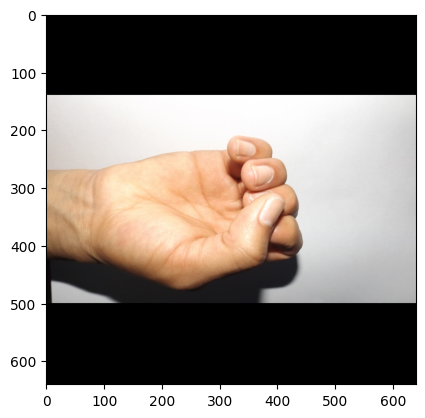

In [8]:
plt.imshow(x_train[100])
plt.show()

## Preprocessing

In [ ]:
clustering_segmentation = ClusteringSegmentation(method='kmeans', n_clusters=3, compactness=30.0, sigma=1.0)
plt.imshow(clustering_segmentation.process(X_train[0]))
plt.show()

In [ ]:
edge_detection = EdgeDetection(method='sobel')
#method: for roberts and canny: image must be 2D
plt.imshow(edge_detection.process(X_train[0]))
plt.show()

In [ ]:
image_restorer = ImageRestorer(method='median')
#'mean_rectangular', 'gaussian', 'adaptive' and 'wiener' generate an error
plt.imshow(image_restorer.process(X_train[0]))
plt.show()

In [ ]:
image_preprocessor = ImagePreprocessor(method = 'CLAHE')
# method = 'log' generates an error
plt.imshow(image_preprocessor.process(X_train[0]))
plt.show()

In [ ]:
region_based_segmentation = RegionBasedSegmentation(method='region_merging')
# method: 'region_splitting' generates an error
plt.imshow(region_based_segmentation.process(X_train[0]))
plt.show()

## Features Extraction

In [ ]:
feature_extractor = FeatureExtractor()

# HOG FEATURES
hog_features = []
#10 images with label = 0
for i in range(10):
    hog_features.append(feature_extractor.extract_hog_features(X_train[i]))
# 10 images with label = 3
for i in range(1000, 1010):
    hog_features.append(feature_extractor.extract_hog_features(X_train[i]))
hog_features = np.array(hog_features)
print(f"hog_features shape: {hog_features.shape}")

# LCP FEATURES
lbp_features = []
for i in range(10):
    lbp_features.append(feature_extractor.extract_lbp_features(rgb2gray(X_train[i])))
lbp_features = np.array(lbp_features)
print(f"lbp_features shape: {lbp_features.shape}")

# PCA FEATURES
pca_features = []
for i in range(10):
    pca_features.append(feature_extractor.extract_pca_features(X_train[i]))
pca_features = np.array(pca_features)
print(f"pca_features shape: {pca_features.shape}")


# SIFT FEATURES (error)
# sift_features = []
# for i in range(10):
#     sift_features.append(feature_extractor.extract_sift_features(X_train[i]))
# sift_features = np.array(sift_features)
# print(f"sift_features shape: {sift_features.shape}")

# FOURIER DESCRIPTOR FEATURES (error)
# fourier_descriptor_features = []
# for i in range(10):
#     fourier_descriptor_features.append(feature_extractor.extract_fourier_descriptor_features(X_train[i]))
# fourier_descriptor_features = np.array(fourier_descriptor_features)
# print(f"fourier_descriptor_features shape: {fourier_descriptor_features.shape}")

# SURF FEATURES (error)

surf_features = []
# for i in range(10):
#     surf_features.append(feature_extractor.extract_surf_features(X_train[i]))
# surf_features = np.array(surf_features)
# print(f"surf_features shape: {surf_features.shape}")

## Feature Selection

## Model Selection

In [ ]:
#true_labels is just for trial here
true_labels = np.concatenate((np.zeros(10), np.ones(10)*3))
model_selection = ModelSelection(hog_features[:15], true_labels[:15], hog_features[15:], true_labels[15:])
knn, y_pred = model_selection.KNN()
print(y_pred)

In [ ]:
performance_analysis = PerformanceAnalysis('KNN', y_pred, true_labels[15:])
performance_analysis.calculate_performance_metrics()